#Review of *Nonlinear Dimensionality Reduction by Locally Linear Embedding* by *Roweis et al.*

##Alex Kerr

This notebook will act as an introduction to the algorithm as presented by *Roweis et al.*

**Citation**:

Nonlinear Dimensionality Reduction by Locally Linear Embedding
Sam T. Roweis and Lawrence K. Saul
Science 22 December 2000: 290 (5500), 2323-2326. [DOI:10.1126/science.290.5500.2323]

Link: http://www.sciencemag.org/content/290/5500/2323.abstract

#Introduction

The motivation behind locally linear embedding (LLE) is to classify high-dimensional data that lie near a lower-dimensional manifold.  A classic function of this algorithm is to map an S-shaped data set to a 2-dimensional manifold as presented in Section 7.5 of Ivezic.

There are 2 main steps to the algorithm: first a set of weights is derived to reconstruct each data point by its $k$th nearest neighbors.  These weights are maintained in the second step in which a lower-dimensional data set is calculated.


# Algorithm Demonstration

I stick to mapping 3D data onto a 2D manifold for visualization purposes, but the concepts translate to higher dimensions.

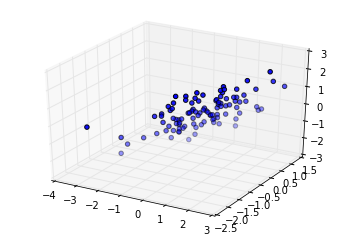

In [2]:
#starting maintenance
%matplotlib inline

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

highD = 3
lowD = 2
N = 100

X = np.random.normal(size = (N,lowD))

R = np.random.random((lowD, highD))

X = np.dot(X,R)

def plot3D(data):
    """An unpythonic (but hopefully readable) function to plot the initial data in 3D"""
    
    x = []
    y = []
    z = []
    
    for datum in data:
        x.append(datum[0])
        y.append(datum[1])
        z.append(datum[2])
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x, y, z, c='b')
    
    plt.show()
    
#plot 3D but awkward in notebook
plot3D(X)


I need to find nearest neighbors of each point.  It turns out we don't need to find the $k$th nearest neighbors; we can opt to find all the other points within a specified radius.

I will however revert to scipy to find the $k$th nearest neighbors

In [3]:
#we need to find the nearest neighbors of each point

from scipy import spatial

def find_neighbors(dataSet):
    
    k = 5
    tree = spatial.KDTree(dataSet)
    
    distList = np.zeros((N,k))
    nList = np.zeros((N,k))
    
    for count in range(N):
        
        n = tree.query(dataSet[count], k = k + 1)
        
        distInfo = n[0]
        indexInfo = n[1]
        
#        print distInfo
#        print indexInfo
        
        distInfo = np.delete(distInfo, 0)
        indexInfo = np.delete(indexInfo, 0)
        
#        print distInfo
#        print indexInfo
        
        distList[count] = distInfo
        nList[count] = indexInfo
        
    return nList
        
nList = find_neighbors(X)


Now that the nearest neighbors have been found, we will calculate our $W$ matrix.

In [4]:
def calculate_W(dataList, nList):
    
    k = np.shape(nList)[1]
    d = np.shape(dataList)[1]
    
    W = np.zeros((N,N))
    
    for count in range(N):
        
        Z = np.zeros((k,d))
        
        neighbors = nList[count]
        
        for i in range(k):
            
            newRow = dataList[neighbors[i]] - dataList[count]
            
            Z[i] = newRow
            
        Z = np.matrix(Z)
            
        C = Z*Z.transpose()
        
        eps = np.trace(C)*1e-3
        
        C = C + eps*np.identity(k)
        
        w = np.linalg.solve(C, np.ones(k))
    
        #normalize        
        w = w/np.sum(w)
        
        for i in range(k):
            
            W[count, neighbors[i]] = w[i]
            
    return W
    
W = calculate_W(X, nList)

With our $W$ in hand, we can calculate our new coordinates.  I have opted to use the scipy linear algebra package because they sort their eigenvectors by their corresponding eigenvalues.

In [5]:
from scipy import linalg

def calculate_new_coords(W):
    
    N = np.shape(W)[0]
    
    I = np.identity(N) - W
    
    M = I.transpose()*I
    
    w, v = linalg.eigh(M)
    
    eVecs = v[1:lowD + 1]
    
    #print eVecs
    
    newDataList = eVecs.transpose()
    
    return newDataList
    
newX = calculate_new_coords(W)

Now we plot our new data.

In [6]:
def plot2D(data):
    
    x = []
    y = []
    
    for datum in data:
        x.append(datum[0])
        y.append(datum[1])
        
    fig = plt.figure()
    
    plt.plot(x, y, 'bo')
    
    plt.show()
    
#plot2D(newX)

Is this kosher?

#sklearn does it better

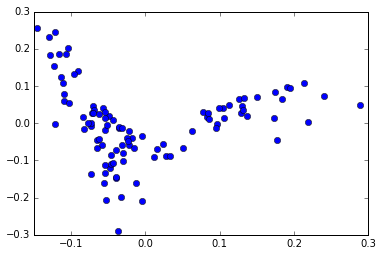

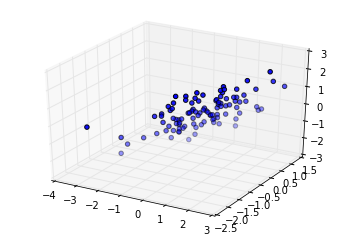

In [10]:
#maintenance

from sklearn.manifold import LocallyLinearEmbedding

k = 5

lle = LocallyLinearEmbedding(k, lowD)
lle.fit(X)
proj = lle.transform(X)

plot2D(proj)
plot3D(X)

Let's test our two methods.

In [8]:
import time

def alex_lle(data):
    
    n = find_neighbors(data)
    W = calculate_W(data, n)
    Y = calculate_new_coords(W)
    
    return Y

def sk_lle(data):
    
    k = 5

    lle = LocallyLinearEmbedding(k, lowD)
    lle.fit(X)
    proj = lle.transform(X)
    
    return proj

start = time.time()

Y = alex_lle(X)

end = time.time()

print "Alex's time:"
print end - start

start = time.time()

Y = sk_lle(X)

end = time.time()

print "SKLearn's time:"
print end - start


    

Alex's time:
0.0722939968109
SKLearn's time:
0.0294048786163


Using pro-built code runs twice as fast in this example.